In [84]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
# from Bio.Seq import Seq
import re
# from Bio import pairwise2
# import itertools
import io
import pyranges as pr
from scipy.stats import zscore
curr_path = '/home/labs/barkailab/matanv/CCCA/context_paper/code/yeast_genome/'
tf_binding_z = zscore(pd.read_csv(curr_path+'tfs_sumprom.csv'),nan_policy='omit')
prom_pos =  np.load(curr_path+'promoter_pos_by_length.npy')
opn_score = pd.read_csv(curr_path+'opn_mine.csv',index_col=0)
gene_id = opn_score.reset_index().drop('opn_score',axis=1)

import _pickle as cPickle
import pickle
import bz2
def decompress_pickle(file):
    '''Load any compressed pickle file.'''
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data
cerGen = decompress_pickle(curr_path+'cerGenome.pbz2')
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42


In [85]:
chr_dict = {1: 'I',
 2: 'II',
 3: 'III',
 4: 'IV',
 5: 'V',
 6: 'VI',
 7: 'VII',
 8: 'VIII',
 9: 'IX',
 10: 'X',
 11: 'XI',
 12: 'XII',
 13: 'XIII',
 14: 'XIV',
 15: 'XV',
 16: 'XVI'}

chr_dict = dict(zip(chr_dict.values(),chr_dict.keys()))
cols = ['Start','End','PeriodSize','STR_size','CopyN','PercentMatch','PercentIndels','Score','A','C','G','T','Entropy','STR','Seq']

In [86]:
with open('Saccer3.2.3.5.80.10.30.6.txt', 'r') as file:
    data = file.read()

In [87]:
parsed_strs = pd.DataFrame()
for i in range(1,len(data.split('Sequence'))-1):
    curr_chromo_dat = data.split('Sequence')[i]
    curr_chromosome = chr_dict[curr_chromo_dat.split('complete sequence')[0].split(' ')[-2].split(',')[0]]
    f = io.StringIO(curr_chromo_dat.split('complete sequence')[1].replace('"',''))
    curr_df = pd.read_csv(f,delim_whitespace=True,header=None,names=cols)
    curr_df['Chromosome'] = curr_df.shape[0]*[curr_chromosome]
    parsed_strs = pd.concat([parsed_strs,curr_df],axis=0)
parsed_strs = parsed_strs.reset_index().drop('index',axis=1)
parsed_strs['Length'] = parsed_strs.End.values-parsed_strs.Start.values
parsed_strs['STR_ID'] = parsed_strs.index


In [43]:
prom_info = pd.DataFrame(prom_pos).astype(int)
prom_info.columns = ['Chromosome','Start','End','Strand']
prom_info.Chromosome = prom_info.Chromosome+1
prom_info['prom_length'] = prom_pos[:,2] - prom_pos[:,1]
prom_info = prom_info.query('Strand!=0')
prom_info = prom_info.drop('Strand',axis=1)
prom_info['prom_length'] = prom_info['prom_length'].astype(int)

In [44]:
per_GC = []
for prom in prom_info.index:
    curr_locs = prom_info.loc[prom,:]
    curr_seq = cerGen['chr'+str(curr_locs['Chromosome'])][curr_locs['Start']:curr_locs['End']]
    per_GC.append((curr_seq.count('G') + curr_seq.count('C')) / len(curr_seq))
prom_info['GC'] = per_GC

In [45]:
sorted_opn = opn_score.reset_index().reset_index().set_index('name')
sorted_opn['opn_score'] = sorted_opn['opn_score'].replace(-np.inf, np.nan)
sorted_opn['opn_score'] = sorted_opn['opn_score'].replace(np.inf, np.nan)

sorted_opn = sorted_opn.dropna().sort_values('opn_score')
sorted_opn.reset_index(inplace=True)
sort_length = []
for curr_id in sorted_opn['index']:
    sort_length.append(prom_info.loc[curr_id,'prom_length'])
sorted_opn['prom_length'] = sort_length
# sorted_opn

In [46]:
combined_pr = pr.PyRanges(prom_info.reset_index()).join(pr.PyRanges(parsed_strs)).df
# print(combined_pr)
# combined_pr = combined_pr.set_index('index')
choreg_right = combined_pr.loc[combined_pr['End_b']>combined_pr['End']].index
combined_pr.loc[choreg_right,'End_b'] = combined_pr.loc[choreg_right,'End']
choreg_left = combined_pr.loc[combined_pr['Start_b']<combined_pr['Start']].index
combined_pr.loc[choreg_left,'Start_b'] = combined_pr.loc[choreg_left,'Start']
combined_pr['STR_prom_len'] = combined_pr['End_b'].values-combined_pr['Start_b'].values
combined_pr['Repeat_unit'] = combined_pr['STR_prom_len']/combined_pr['CopyN']
combined_pr = combined_pr.set_index('index').drop([526, 1487],axis=0).reset_index()
# combined_pr['Repeat_unit'] = combined_pr['Repeat_unit'].astype(int)
# combined_pr = combined_pr.reset_index()
# combined_pr
non_rep_STRs = combined_pr.loc[:,['STR_ID','STR_prom_len']].groupby('STR_ID').idxmax().values.flatten()
combined_pr = combined_pr.loc[non_rep_STRs,:]
match_thrs = 80
combined_pr = combined_pr.query("PercentMatch>@match_thrs")

In [47]:
fin_df = pd.DataFrame()
num_tf_bound = ((tf_binding_z>3).sum(axis=1)).loc[prom_info.index]
# num_tf_bound = num_tf_bound.loc[prom_info.index]
mean_prom_GC = []
bound_bins = [0,1,2,3,5,num_tf_bound.max()]
p_number = []
for i in range(len(bound_bins)-1):
    # print(((num_tf_bound>=bound_bins[i]) & (num_tf_bound<bound_bins[i+1])).sum())
    curr_set = num_tf_bound.loc[((num_tf_bound>=bound_bins[i]) & (num_tf_bound<bound_bins[i+1]))].index
    p_number.append(curr_set.shape[0])
    mean_prom_GC.append(prom_info.loc[curr_set,'GC'].mean())
    set_strs = list(set(combined_pr['index'].values).intersection(curr_set))
    set_strs = combined_pr.reset_index().set_index('index').loc[set_strs]
    set_strs = set_strs.iloc[set_strs.reset_index().loc[:,['index','Repeat_unit']].groupby('index').idxmax().Repeat_unit]
    set_strs = set_strs.query('PeriodSize>1')
    num_bound = num_tf_bound.loc[set_strs.index].values

    tss_dist = []
    who_str = []
    who_prom = []
    rep_unit = []
    for idx in set_strs.index:
        who_str.append(set_strs.loc[idx]['STR'])
        who_prom.append(gene_id.loc[idx]['name'])
        rep_unit.append(set_strs.loc[idx]['Repeat_unit'])
        if prom_pos[idx,3]>1:
            tss_dist.append(set_strs.loc[idx,'Start_b']-set_strs.loc[idx,'Start'])
        else:
            tss_dist.append(set_strs.loc[idx,'End']-set_strs.loc[idx,'End_b'])
    mb_summary = pd.DataFrame([who_str,num_bound,tss_dist,rep_unit],columns=[who_prom]).T
    mb_summary.columns = ['STR','TF_number','Distance_tss','number_of_reps']
    mb_summary['set'] = [str(bound_bins[i]) + '-' + str(bound_bins[i+1])]*mb_summary.shape[0]
    fin_df = pd.concat([fin_df,mb_summary])
mfunc = lambda x:(x.count('G') + x.count('C')) / len(x)
fin_df['STR_GC'] = fin_df['STR'].apply(mfunc).values
# sns.barplot(x=fin_df['set'].value_counts(sort=False).index,y=fin_df['set'].value_counts(sort=False).values/p_number)

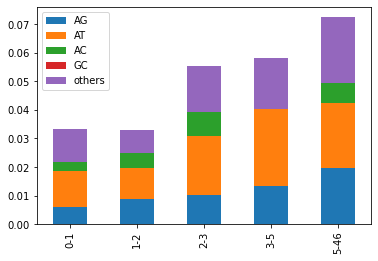

In [48]:
min_rep = 2
fin_df = fin_df.query('number_of_reps>@min_rep')
count_types = pd.DataFrame()
cols = []
for i in range(len(bound_bins)-1):
    cols.append(str(bound_bins[i]) + '-' + str(bound_bins[i+1]))
    curr_bin = str(bound_bins[i]) + '-' + str(bound_bins[i+1])
    
    df_sub = fin_df.query('set==@curr_bin').copy()
    curr_STRs = df_sub['STR'].values
    num_AG = len([s for s in curr_STRs if all(c in 'AG' for c in s) or all(c in 'TC' for c in s)])
    num_AT = len([s for s in curr_STRs if all(c in 'AT' for c in s)])
    num_AC = len([s for s in curr_STRs if all(c in 'AC' for c in s) or all(c in 'GT' for c in s)])
    num_GC = len([s for s in curr_STRs if all(c in 'GC' for c in s)])
    num_others = len(curr_STRs)-num_AG-num_AT-num_AC-num_GC
    count_types = pd.concat([count_types,pd.Series(np.array([num_AG,num_AT,num_AC,num_GC,num_others])/p_number[i])],axis=1)
count_types.columns = cols
count_types.index = ['AG','AT','AC','GC','others']
count_types.T.plot(kind='bar', stacked=True)
# fig = ax.get_figure()
plt.savefig('frac_strs_boundproms.pdf')


In [49]:
p_number

[2921, 1120, 486, 448, 565]

Text(0.5, 0, 'Percent match')

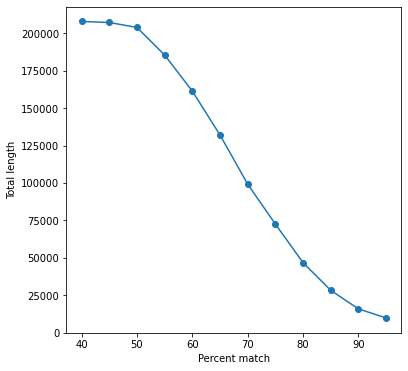

In [50]:
thresh_range = np.arange(40,100,5)
total_length = []
for thresh in thresh_range:
    total_length.append(parsed_strs.loc[parsed_strs.PercentMatch>thresh]['Length'].sum())
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(thresh_range,total_length,marker='o')
ax.set_ylabel('Total length')
ax.set_xlabel('Percent match')

Text(0.5, 0, 'Percent match')

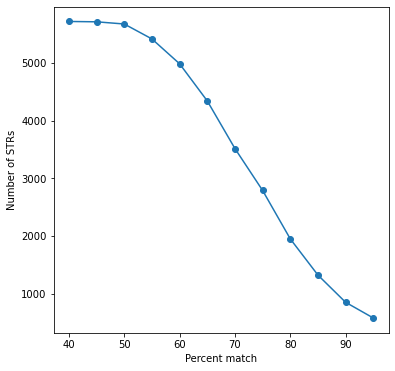

In [17]:
thresh_range = np.arange(40,100,5)
num_reps = []
for thresh in thresh_range:
    num_reps.append(parsed_strs.loc[parsed_strs.PercentMatch>thresh]['Length'].shape[0])
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(thresh_range,num_reps,marker='o')
ax.set_ylabel('Number of STRs')
ax.set_xlabel('Percent match')

<AxesSubplot:xlabel='PeriodSize', ylabel='Density'>

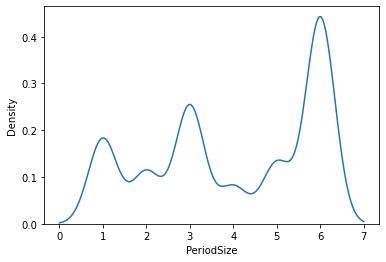

In [18]:
sns.kdeplot(parsed_strs.PeriodSize)

In [19]:
combined_pr_filtered = combined_pr.query("PercentMatch>@match_thrs").copy()
num_strs = []
total_str_length = []
for prom in sorted_opn['index']:
    total_str_length.append(combined_pr.query('index==@prom')['STR_prom_len'].sum())
    num_strs.append(combined_pr.query('index==@prom').shape[0])    
sorted_opn['total_str_length'] = total_str_length
sorted_opn['num_strs'] = num_strs
sorted_opn['norm_total'] = sorted_opn['total_str_length']/sorted_opn['prom_length']
sorted_opn['norm_num'] = sorted_opn['num_strs']/sorted_opn['prom_length']


Text(0.5, 0, 'OPN Score')

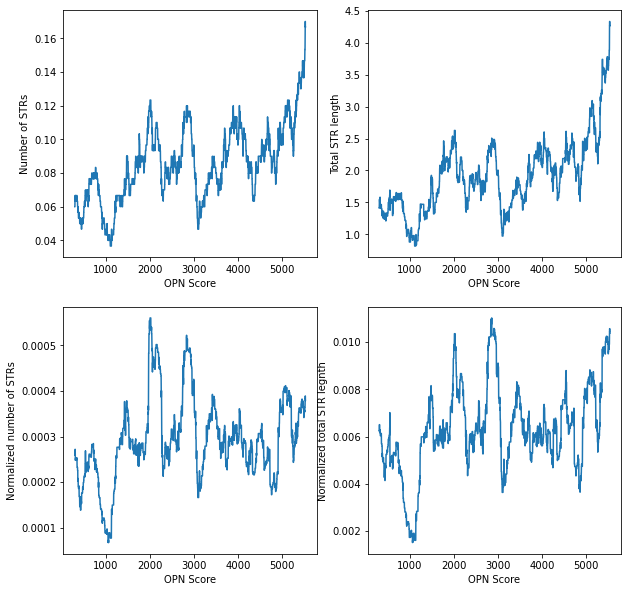

In [20]:
window = 300
fig,axes = plt.subplots(2,2,figsize=(10,10))

axes.ravel()[0].plot(sorted_opn['num_strs'].rolling(window).mean())
axes.ravel()[0].set_ylabel('Number of STRs')
axes.ravel()[0].set_xlabel('OPN Score')

axes.ravel()[1].plot(sorted_opn['total_str_length'].rolling(window).mean())
axes.ravel()[1].set_ylabel('Total STR length')
axes.ravel()[1].set_xlabel('OPN Score')


axes.ravel()[2].plot(sorted_opn['norm_num'].rolling(window).mean())
axes.ravel()[2].set_ylabel('Normalized number of STRs')
axes.ravel()[2].set_xlabel('OPN Score')

axes.ravel()[3].plot(sorted_opn['norm_total'].rolling(window).mean())
axes.ravel()[3].set_ylabel('Normalized total STR legnth')
axes.ravel()[3].set_xlabel('OPN Score')


<AxesSubplot:xlabel='Length', ylabel='Density'>

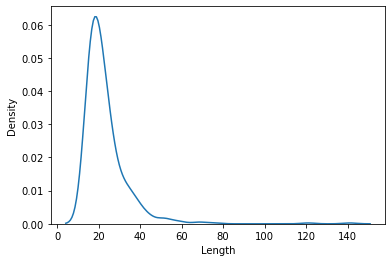

In [21]:
sns.kdeplot(combined_pr['Length'])

<AxesSubplot:xlabel='num_strs', ylabel='Density'>

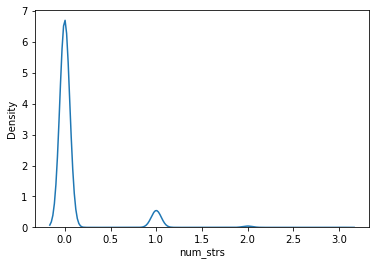

In [22]:
sns.kdeplot(sorted_opn['num_strs'])

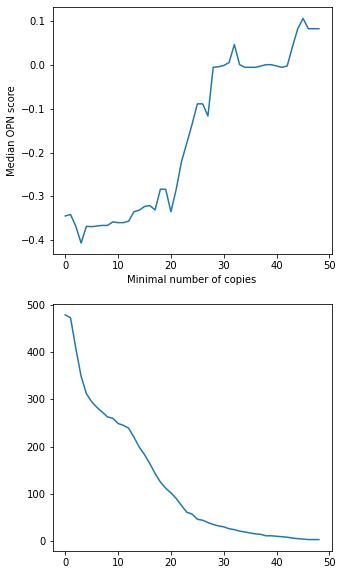

In [23]:
opn_avg = []
mlen = []
upper_rep = 50
sorted_opn.set_index('index',inplace=True)
for thresh in range(1,upper_rep,1):
    opn_avg.append(sorted_opn.loc[combined_pr.query('Repeat_unit>@thresh')['index'].values]['opn_score'].median())
    mlen.append(sorted_opn.loc[combined_pr.query('Repeat_unit>@thresh')['index'].values].shape[0])
fig,axes = plt.subplots(2,1,figsize=(5,10))
axes[0].plot(opn_avg)
axes[0].set_xlabel('Minimal number of copies')
axes[0].set_ylabel('Median OPN score')
axes[1].plot(mlen)

In [24]:
z_thresh = 3

m2_proms_strs = list(set(combined_pr['index'].values).intersection(tf_binding_z.query('Msn2>@z_thresh').index))
m2_proms_strs = combined_pr.set_index('index').loc[m2_proms_strs]
m2_proms_strs = m2_proms_strs.iloc[m2_proms_strs.reset_index().loc[:,['index','Repeat_unit']].groupby('index').idxmax().Repeat_unit]
m2_proms_strs = m2_proms_strs.query('PeriodSize>1')


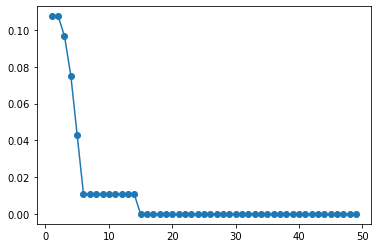

In [25]:
frac_m2proms_passed = []
upper_lim = 50
for i in range(1,upper_lim,1):
    frac_m2proms_passed.append(m2_proms_strs.query('Repeat_unit>@i').shape[0]/len(tf_binding_z.query('Msn2>@z_thresh').index))
plt.plot(range(1,upper_lim,1),frac_m2proms_passed,marker='o')

In [26]:
long_m2_strs = m2_proms_strs.query('Repeat_unit>2')
tss_dist = []
who_str = []
zscoreb = []
who_prom = []
rep_unit = []
for idx in long_m2_strs.index:
    zscoreb.append(tf_binding_z['Msn2'][idx])
    who_str.append(long_m2_strs.loc[idx]['STR'])
    who_prom.append(sorted_opn.loc[idx]['name'])
    rep_unit.append(long_m2_strs.loc[idx]['Repeat_unit'])
    if prom_pos[idx,3]>1:
        tss_dist.append(long_m2_strs.loc[idx,'Start_b']-long_m2_strs.loc[idx,'Start'])
    else:
        tss_dist.append(long_m2_strs.loc[idx,'End']-long_m2_strs.loc[idx,'End_b'])

In [27]:
m2_summary = pd.DataFrame([who_str,zscoreb,tss_dist,rep_unit],columns=[who_prom]).T
m2_summary.columns = ['STR','z-score','Distance_tss','Units of repeats']
m2_summary

,STR,z-score,Distance_tss,Units of repeats
TPS1,CCCTG,8.832023,169,4.0
YDL124W,AT,9.462461,45,14.5
IPT1,TTTTTA,3.124965,681,2.333333
VHS1,ATTT,3.404206,131,4.75
HSP12,GGAAAA,6.552471,281,5.5
GSY1,TTGCTG,9.353305,382,3.333333
IGD1,TATATA,3.036024,651,6.0
MCR1,CATCA,4.733003,409,5.0
TMA10,CCATAT,3.282632,536,4.333333
SUR1,GACGC,4.116303,318,5.2


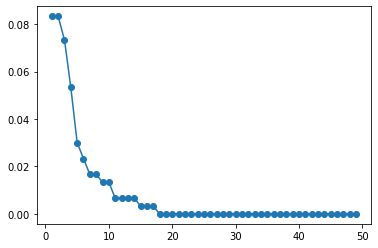

In [28]:
how_many_proms = 300
most_bound = (tf_binding_z>3).sum(axis=1).sort_values(ascending=False)[:how_many_proms].index

most_bound_proms_strs = list(set(combined_pr['index'].values).intersection(most_bound))
most_bound_proms_strs = combined_pr.reset_index().set_index('index').loc[most_bound_proms_strs]
most_bound_proms_strs = most_bound_proms_strs.iloc[most_bound_proms_strs.reset_index().loc[:,['index','Repeat_unit']].groupby('index').idxmax().Repeat_unit]
most_bound_proms_strs = most_bound_proms_strs.query('PeriodSize>1')
top_vals = (tf_binding_z>3).sum(axis=1).sort_values(ascending=False)[:how_many_proms].values

tss_dist = []
who_str = []
how_many = []
who_prom = []
rep_unit = []
for i,idx in enumerate(most_bound_proms_strs.index):
    how_many.append(top_vals[i])
    who_str.append(most_bound_proms_strs.loc[idx]['STR'])
    who_prom.append(sorted_opn.loc[idx]['name'])
    rep_unit.append(most_bound_proms_strs.loc[idx]['Repeat_unit'])
    if prom_pos[idx,3]>1:
        tss_dist.append(most_bound_proms_strs.loc[idx,'Start_b']-most_bound_proms_strs.loc[idx,'Start'])
    else:
        tss_dist.append(most_bound_proms_strs.loc[idx,'End']-most_bound_proms_strs.loc[idx,'End_b'])
        
frac_most_passed = []
upper_lim = 50
for i in range(1,upper_lim,1):
    frac_most_passed.append(most_bound_proms_strs.query('Repeat_unit>@i').shape[0]/len(top_vals))
plt.plot(range(1,upper_lim,1),frac_most_passed,marker='o')
plt.show()

In [29]:
mb_summary = pd.DataFrame([who_str,how_many,tss_dist,rep_unit],columns=[who_prom]).T
mb_summary.columns = ['STR','TF number','Distance_tss','Units of repeats']
mb_summary

,STR,TF number,Distance_tss,Units of repeats
CDC19,TTGAG,46,351,3.8
PRE7,TTTCTTC,43,482,2.428571
TPS1,CCCTG,43,169,4.0
AMN1,AT,42,60,7.0
YDL124W,AT,42,45,14.5
CDC34,AGAA,40,301,4.75
IPT1,TTTTTA,40,681,2.333333
VHS1,ATTT,39,131,4.75
ANP1,AGAAA,36,474,10.6
MIG3,ATTAAA,36,21,2.5


In [30]:
n_proms = 300
num_tf_bound = (tf_binding_z>3).sum(axis=1)
top_prom_set = num_tf_bound.sort_values(ascending=False)[:n_proms].index
bottom_prom_set = num_tf_bound.sort_values()[:n_proms].index
sets = [top_prom_set,bottom_prom_set,tf_binding_z.sample(n=n_proms).index,tf_binding_z.sample(n=n_proms).index
        ,tf_binding_z.sample(n=n_proms).index,tf_binding_z.sample(n=n_proms).index]
info_list = ['top','bottom','rand1','rand2','rand3','rand4']

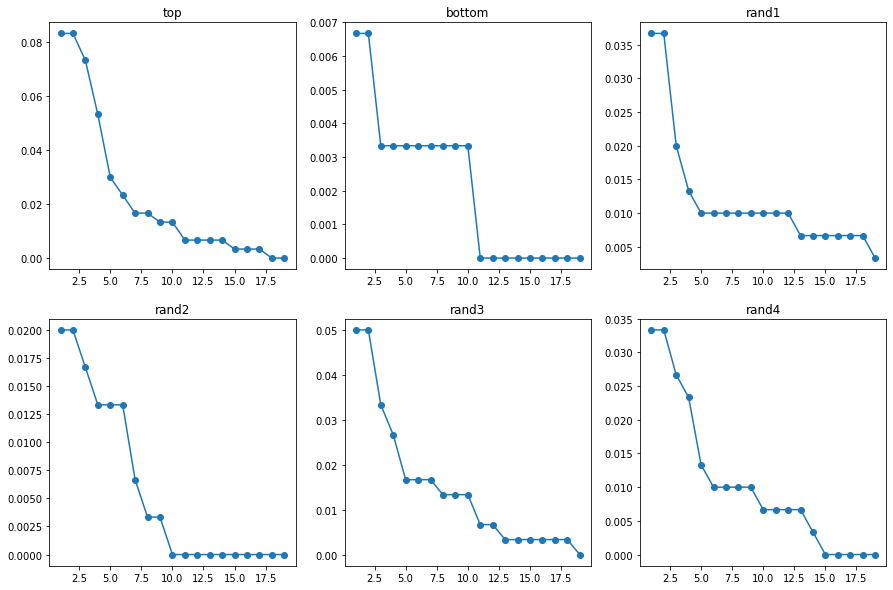

In [31]:
fin_df = pd.DataFrame()
fig, axes = plt.subplots(2,3,figsize=(15,10))
for i,curr_set in enumerate(sets):
    set_strs = list(set(combined_pr['index'].values).intersection(curr_set))
    set_strs = combined_pr.reset_index().set_index('index').loc[set_strs]
    set_strs = set_strs.iloc[set_strs.reset_index().loc[:,['index','Repeat_unit']].groupby('index').idxmax().Repeat_unit]
    set_strs = set_strs.query('PeriodSize>1')
    num_bound = num_tf_bound.loc[set_strs.index].values

    tss_dist = []
    who_str = []
    who_prom = []
    rep_unit = []
    for idx in set_strs.index:
        who_str.append(set_strs.loc[idx]['STR'])
        who_prom.append(sorted_opn.loc[idx]['name'])
        rep_unit.append(set_strs.loc[idx]['Repeat_unit'])
        if prom_pos[idx,3]>1:
            tss_dist.append(set_strs.loc[idx,'Start_b']-set_strs.loc[idx,'Start'])
        else:
            tss_dist.append(set_strs.loc[idx,'End']-set_strs.loc[idx,'End_b'])
    mb_summary = pd.DataFrame([who_str,num_bound,tss_dist,rep_unit],columns=[who_prom]).T
    mb_summary.columns = ['STR','TF number','Distance_tss','Units of repeats']
    mb_summary['set'] = [info_list[i]]*set_strs.shape[0]
    fin_df = pd.concat([fin_df,mb_summary])
    upper_lim = 20
    frac_most_passed = []
    for j in range(1,upper_lim,1):
        frac_most_passed.append(set_strs.query('Repeat_unit>@j').shape[0]/n_proms)
    curr_ax = axes.ravel()[i]
    curr_ax.plot(range(1,upper_lim,1),frac_most_passed,marker='o')
    curr_ax.set_title(info_list[i])
fin_df.to_csv('output.csv')

In [32]:
fin_df['TF number'].values

array([9, 11, 16, 18, 24, 9, 23, 15, 9, 13, 21, 17, 17, 42, 27, 17, 11,
       15, 18, 30, 19, 33, 15, 12, 8, 0, 0, 2, 1, 23, 1, 4, 2, 0, 4, 1, 2,
       2, 18, 2, 0, 0, 0, 1, 0, 2, 0, 1, 1, 3, 3, 0, 2, 2, 15, 0, 0, 15,
       1, 1, 0, 1, 9, 0, 1, 0, 0, 0, 4], dtype=object)

In [33]:
n_proms = 300
num_tf_bound = (tf_binding_z>3).sum(axis=1)
sort_bound = num_tf_bound.sort_values(ascending=False).index

In [34]:
fin_df = pd.DataFrame()

for i in range(0,len(sort_bound),n_proms):
    curr_set = sort_bound[i:i+n_proms-1]
    set_strs = list(set(combined_pr['index'].values).intersection(curr_set))
    set_strs = combined_pr.reset_index().set_index('index').loc[set_strs]
    set_strs = set_strs.iloc[set_strs.reset_index().loc[:,['index','Repeat_unit']].groupby('index').idxmax().Repeat_unit]
    set_strs = set_strs.query('PeriodSize>1')
    num_bound = num_tf_bound.loc[set_strs.index].values

    tss_dist = []
    who_str = []
    who_prom = []
    rep_unit = []
    for idx in set_strs.index:
        who_str.append(set_strs.loc[idx]['STR'])
        who_prom.append(gene_id.loc[idx]['name'])
        rep_unit.append(set_strs.loc[idx]['Repeat_unit'])
        if prom_pos[idx,3]>1:
            tss_dist.append(set_strs.loc[idx,'Start_b']-set_strs.loc[idx,'Start'])
        else:
            tss_dist.append(set_strs.loc[idx,'End']-set_strs.loc[idx,'End_b'])
    mb_summary = pd.DataFrame([who_str,num_bound,tss_dist,rep_unit],columns=[who_prom]).T
    mb_summary.columns = ['STR','TF_number','Distance_tss','number_of_reps']
    mb_summary['set'] = [str(i+1) + '-' + str(i+n_proms)]*mb_summary.shape[0]
    fin_df = pd.concat([fin_df,mb_summary])
    # upper_lim = 20
    # frac_most_passed = []
    # for j in range(1,upper_lim,1):
    #     frac_most_passed.append(set_strs.query('Repeat_unit>@j').shape[0]/n_proms)
    # curr_ax = axes.ravel()[i]
    # curr_ax.plot(range(1,upper_lim,1),frac_most_passed,marker='o')
    # curr_ax.set_title(info_list[i])
# fin_df.to_csv('output.csv')

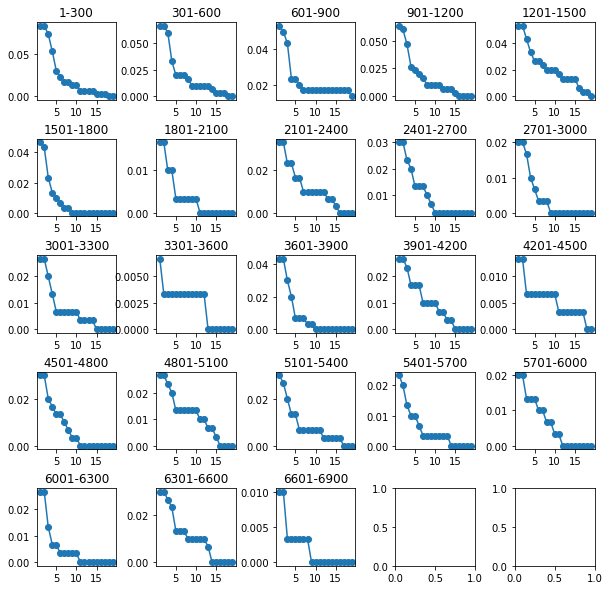

In [35]:
fig, axes = plt.subplots(5,5,figsize=(10,10))
fig.subplots_adjust(hspace=0.5,wspace=0.5)
upper_limit = 20
for i,curr_set in enumerate(fin_df['set'].unique()):
    curr_df = fin_df.query('set==@curr_set')
    frac_most_passed = []
    curr_ax = axes.ravel()[i]
    for j in range(1,upper_limit,1):
        frac_most_passed.append(curr_df.query('number_of_reps>@j').shape[0]/n_proms)
        
    curr_ax.plot(range(1,upper_limit,1),frac_most_passed,marker='o')
    curr_ax.set_title(curr_set)
fin_df.to_csv('every300.csv')

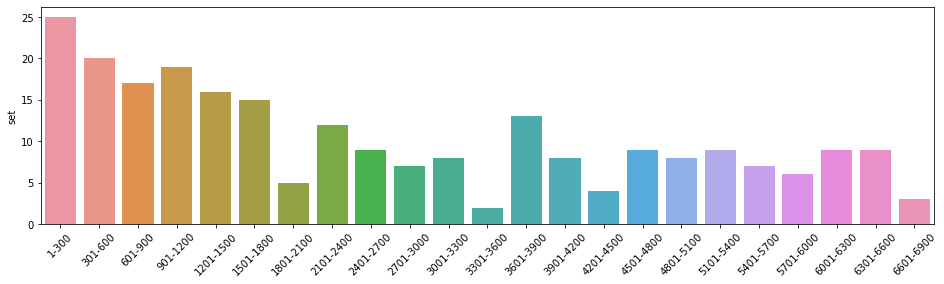

In [36]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
sns.barplot(x=fin_df['set'].value_counts(sort=False).index,y=fin_df['set'].value_counts(sort=False))
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:>

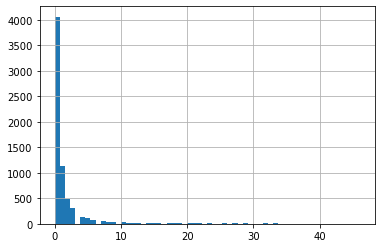

In [37]:
num_tf_bound.hist(bins=60)

In [38]:
plt.scatter(mean_prom_GC,fin_df[['set','STR_GC']].groupby('set').median().values)

KeyError: "['STR_GC'] not in index"

In [ ]:
gc_df = pd.concat([pd.Series(mean_prom_GC),pd.Series(fin_df[['set','STR_GC']].groupby('set').median().values.flatten())],axis=1)
gc_df.index = fin_df[['set','STR_GC']].groupby('set').median().index
sns.scatterplot(data=gc_df,x=0,y=1)
for i, txt in enumerate(gc_df.index):
    plt.annotate(txt, (gc_df[0][i], gc_df[1][i]), textcoords="offset points", xytext=(0,10), ha='center')

Index(['0-1', '1-2', '2-3', '3-5', '5-100'], dtype='object', name='set')

,STR,TF_number,Distance_tss,number_of_reps,set,STR_GC
CYS3,GAAAA,0,85,3.4,0-1,0.200000
PSK1,ATCTAT,0,179,5.0,0-1,0.166667
GDH3,AT,0,382,14.5,0-1,0.000000
CDC15,TGCCCA,0,0,2.166667,0-1,0.666667
RRN10,GTTTT,0,92,2.8,0-1,0.200000
...,...,...,...,...,...,...
LEE1,TTTGTA,19,198,3.5,5-100,0.166667
SUR1,GACGC,33,318,5.2,5-100,0.800000
YPR015C,AT,15,71,11.0,5-100,0.000000
MEP3,AT,12,279,8.5,5-100,0.000000


0.40682299456183874

In [ ]:
for i in range(len(bound_bins)-1):
    curr_set = num_tf_bound.loc[((num_tf_bound>=bound_bins[i]) & (num_tf_bound<bound_bins[i+1]))].index
curr_set

In [ ]:
cerGen.keys()

In [ ]:
curr = prom_info.iloc[0,:]
curr_seq = cerGen['chr'+str(curr['Chromosome'])][curr['Start']:curr['End']]

